In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
# Load and preprocess data
def load_data(data_dir, img_size=(128, 128)):
    X, y = [], []
    labels = {'normal': 0, 'abnormal': 1}
    for label in labels:
        path = os.path.join(data_dir, label)
        for img_name in os.listdir(path):
            img = cv2.imread(os.path.join(path, img_name))
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(labels[label])
    return np.array(X) / 255.0, np.array(y)

# Load dataset
data_dir = "Batch"  # Change to your dataset path
X, y = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# CNN Model
def create_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    return model

In [6]:
# Train CNN with different optimizers and compare performance
optimizers = {'Adam': Adam(), 'SGD': SGD(), 'RMSprop': RMSprop()}
performance_results = {}

for opt_name, optimizer in optimizers.items():
    model = create_cnn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    results = model.evaluate(X_test, y_test)
    performance_results[opt_name] = {
        "Loss": results[0],
        "Accuracy": results[1],
        "Precision": results[2],
        "Recall": results[3]
    }

print("Performance Comparison of Optimizers:")
for opt, metrics in performance_results.items():
    print(f"{opt} - Loss: {metrics['Loss']}, Accuracy: {metrics['Accuracy']}, Precision: {metrics['Precision']}, Recall: {metrics['Recall']}")

# Feature Extraction
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)


Epoch 1/10
50/50 [==============================] - 35s 628ms/step - loss: 6.3780 - accuracy: 0.6681 - precision: 0.6675 - recall: 0.6683 - val_loss: 5.1441 - val_accuracy: 0.5575 - val_precision: 0.5331 - val_recall: 0.9602
Epoch 2/10
50/50 [==============================] - 31s 629ms/step - loss: 5.2754 - accuracy: 0.8156 - precision: 0.8166 - recall: 0.8135 - val_loss: 5.6499 - val_accuracy: 0.5025 - val_precision: 0.5025 - val_recall: 1.0000
Epoch 3/10
50/50 [==============================] - 30s 603ms/step - loss: 4.5024 - accuracy: 0.8606 - precision: 0.8600 - recall: 0.8611 - val_loss: 7.3450 - val_accuracy: 0.5025 - val_precision: 0.5025 - val_recall: 1.0000
Epoch 4/10
50/50 [==============================] - 30s 607ms/step - loss: 3.7559 - accuracy: 0.9062 - precision: 0.9031 - recall: 0.9099 - val_loss: 4.0028 - val_accuracy: 0.5550 - val_precision: 0.5308 - val_recall: 0.9851
Epoch 5/10
50/50 [==============================] - 29s 575ms/step - loss: 3.2307 - accuracy: 0.9087

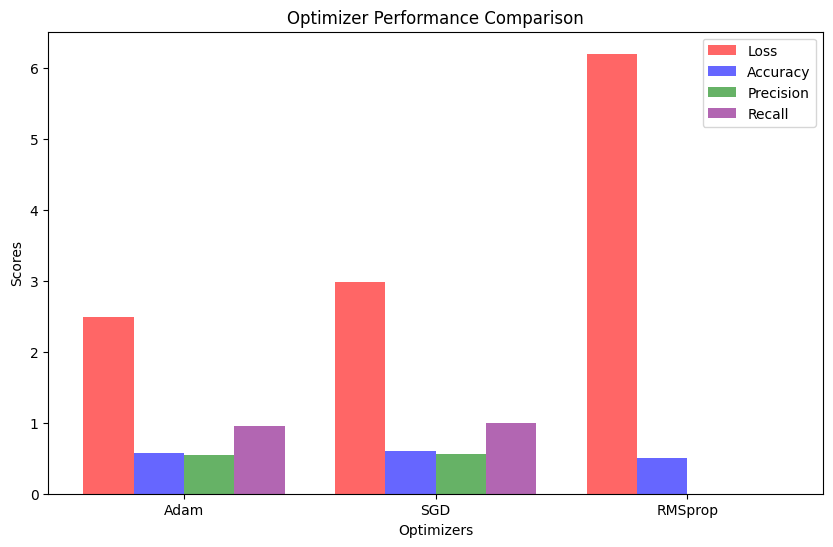

In [7]:
# Plotting Results
optimizers = list(performance_results.keys())
loss_values = [performance_results[opt]['Loss'] for opt in optimizers]
accuracy_values = [performance_results[opt]['Accuracy'] for opt in optimizers]
precision_values = [performance_results[opt]['Precision'] for opt in optimizers]
recall_values = [performance_results[opt]['Recall'] for opt in optimizers]

x = np.arange(len(optimizers))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*bar_width, loss_values, bar_width, label='Loss', color='red', alpha=0.6)
ax.bar(x - 0.5*bar_width, accuracy_values, bar_width, label='Accuracy', color='blue', alpha=0.6)
ax.bar(x + 0.5*bar_width, precision_values, bar_width, label='Precision', color='green', alpha=0.6)
ax.bar(x + 1.5*bar_width, recall_values, bar_width, label='Recall', color='purple', alpha=0.6)

ax.set_xlabel('Optimizers')
ax.set_ylabel('Scores')
plt.xticks(x, optimizers)
plt.title('Optimizer Performance Comparison')
ax.legend()
plt.show()

Random Forest Results:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       199
           1       0.83      0.83      0.83       201

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

SVM Results:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       199
           1       0.78      0.79      0.79       201

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400

kNN Results:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       199
           1       0.80      0.87      0.83       201

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83  

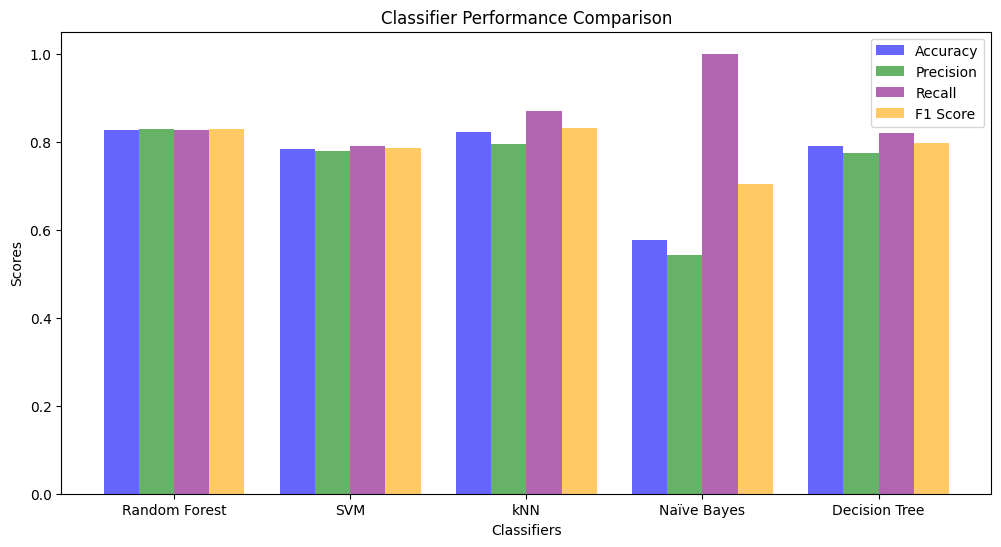

In [10]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
# Standard classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Naïve Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

classifier_results = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train_features, y_train)
    y_pred = clf.predict(X_test_features)
    classifier_results[clf_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    print(f"{clf_name} Results:")
    print(classification_report(y_test, y_pred))

# Plotting Classifier Results
classifiers_list = list(classifier_results.keys())
accuracy_vals = [classifier_results[clf]['Accuracy'] for clf in classifiers_list]
precision_vals = [classifier_results[clf]['Precision'] for clf in classifiers_list]
recall_vals = [classifier_results[clf]['Recall'] for clf in classifiers_list]
f1_vals = [classifier_results[clf]['F1 Score'] for clf in classifiers_list]

x = np.arange(len(classifiers_list))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - 1.5*bar_width, accuracy_vals, bar_width, label='Accuracy', color='blue', alpha=0.6)
ax.bar(x - 0.5*bar_width, precision_vals, bar_width, label='Precision', color='green', alpha=0.6)
ax.bar(x + 0.5*bar_width, recall_vals, bar_width, label='Recall', color='purple', alpha=0.6)
ax.bar(x + 1.5*bar_width, f1_vals, bar_width, label='F1 Score', color='orange', alpha=0.6)

ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
plt.xticks(x, classifiers_list)
plt.title('Classifier Performance Comparison')
ax.legend()
plt.show()
